# Carte d'activation individuelle
## Premier niveau d'analyse
Note: ce [tutoriel](https://nistats.github.io/auto_examples/01_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-01-tutorials-plot-single-subject-single-run-py) est tiré de la documentation de la librairie NiStats

In [1]:
!pip show nistats
#!pip install nistats

Name: nistats
Version: 0.0.1rc0
Summary: Modeling and Statistical analysis of fMRI data in Python
Home-page: http://nistats.github.io
Author: None
Author-email: None
License: new BSD
Location: c:\users\sangfrois\documents\computation\anaconda3\envs\sangfroisenv\lib\site-packages
Requires: nilearn, numpy, nibabel, pandas, scikit-learn, scipy
Required-by: 


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Objectifs 
On a collecté des signaux d'IRMf pendant une tâche de stimulation auditive. On veut donc modéliser les réponses hémodynamiques associées aux stimulations à l'aide du modèle général linéaire (GLM).

Nous allons passer les étapes de pré-traitements des signaux et revenir principalement sur la notion de design de tâche en blocs. Nous allons également préciser comment il est possible de régresser l'activation neurovasculaire associée à la tâche. Ensuite, nous allons voir comment tester et visualiser les voxels qui démontrent une activation significativement différente de la condition contrôle.

**1) Importer des données**

**2) Localiser l'activité dans un volume stable**

**3) Spécifier la séquence des événements (design de la tâche)**

**4) Estimation des réponses associées aux événements**

**5) Calculer/Visualiser les réponses significatives**

## Importer des données
L'ensemble de données provient d'une expérience menée au FIL par Geriant Rees
sous la direction de Karl Friston. 

Selon la documentation du logiciel SPM (duquel est tiré les données), 96 scans ont été acquis (temps de répétition TR=7s) en une session. Le paradigme consistait à alterner des périodes de stimulation et de repos, d'une durée de 42s chacune (soit pour 6 scans). La sesssion commençait par un bloc de repos.
La stimulation auditive consistait en des mots bi-syllabiques à raison de 60/minute

   * 1 Session = 96 scans = 16 blocs
   * 1 Bloc = 42s
   * TR = 7s
   * 6 scans complets par bloc

In [4]:
from nistats.datasets import fetch_spm_auditory
subject_data = fetch_spm_auditory()

C:\Users\sangfrois\Documents\Computation\Anaconda3\envs\sangfroisEnv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 

 | Starting with Nilearn 0.7.0, all Nistats functionality has been incorporated into Nilearn's stats & reporting modules.
 | Nistats package will no longer be updated or maintained.

  """Entry point for launching an IPython kernel.


Voyons le premier volume de la série ainsi que le scan anatomique de notre sujet

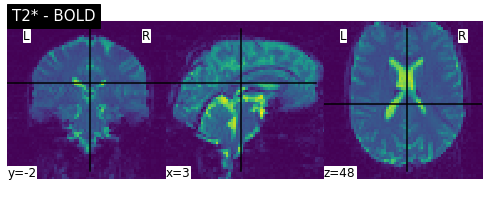

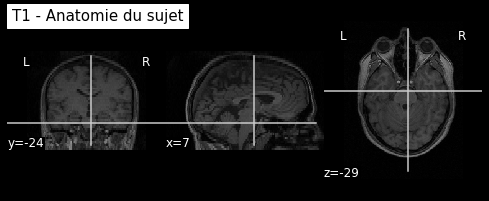

In [5]:
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
plot_img(subject_data.func[0], title='T2* - BOLD')
plot_anat(subject_data.anat, title='T1 - Anatomie du sujet')

### Volume stable
Ensuite, nous concaténons toutes les volumes BOLD en une seule image 4D,
puis nous faisons la moyenne de ces données afin de créer une image de fond
qui sera utilisée pour afficher les activations :


In [6]:
from nilearn.image import concat_imgs, mean_img
fmri_img = concat_imgs(subject_data.func)
mean_img = mean_img(fmri_img)

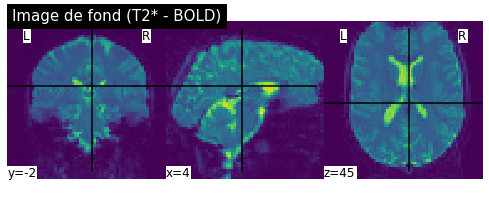

In [7]:
plot_img(mean_img, title='Image de fond (T2* - BOLD)')

Spécifier la séquence des événements expérimentaux
------------------------------------
Nous devons fournir une description de l'expérience, c'est-à-dire définir les
le moment de la stimulation auditive et des périodes de repos. Il s'agit généralement
fourni dans un fichier events.tsv. Le chemin de ce fichier est
fournies dans le jeu de données.

Ici, la variable `subject_data` est un dictionaire dont la clé `['events']` contient la séquence d'événements

In [8]:
subject_data.keys()

dict_keys(['func', 'anat', 'events'])

In [9]:
import pandas as pd # pandas est une librairie qui effectue une tâche similaire à excel
events = pd.read_table(subject_data['events'])
events

,onset,duration,trial_type
0,0.0,42.0,rest
1,42.0,42.0,active
2,84.0,42.0,rest
3,126.0,42.0,active
4,168.0,42.0,rest
5,210.0,42.0,active
6,252.0,42.0,rest
7,294.0,42.0,active
8,336.0,42.0,rest
9,378.0,42.0,active


Estimation de l'activité BOLD associée
---------------------------
`FirstLevelModel`correspond à un modèle individuel (subject-level). Comme spécifier dans le cours, il est nécessaire de régresser les signaux IRMf à l'aide du modèle de la réponse hémodynamique.

Pragmatiquement, chaque voxel fluctue dans le temps. Nous voulons savoir à quel point cette fluctuation correspond au modèle de la réponse hémodynamique au temps *t*.

On aura donc 2 coefficients de régression pour chaque voxel afin de mesurer si son activation est associé à un événement en particulier. Un coefficient pour chaque condition (rest, et active). 

Évidemment, ce qui nous intéresse ce sont les voxels associés à la condition de stimulation auditive. On veut connaître ceux qui ont un niveau significativement plus élevé que la contrôle  

In [10]:
from nistats.first_level_model import FirstLevelModel

C:\Users\sangfrois\Documents\Computation\Anaconda3\envs\sangfroisEnv\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


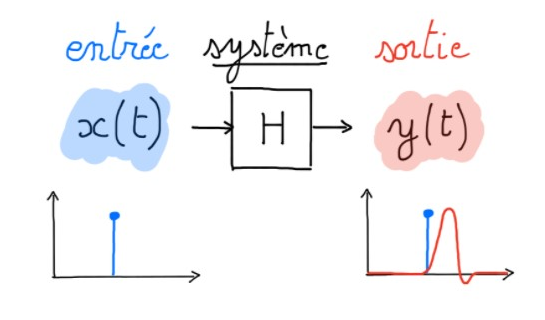

Paramètres du modèle individuel. Ceci nous permet de spécifier la forme attendue de les réponses hémodynamiques

In [11]:
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

Maintenant, on veut calculer les coefficient. Estimer la réponse réelle.
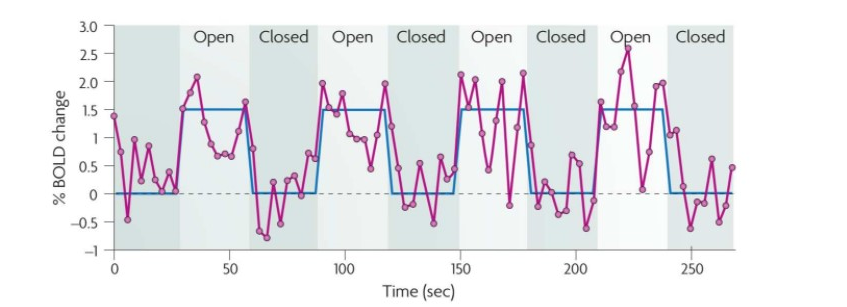

In [12]:
fmri_glm = fmri_glm.fit(fmri_img, events)

`design_matrix` représente la séquence d'évenement.



In [13]:
design_matrix = fmri_glm.design_matrices_[0]

Nous nous attarderons aux blocs expérimentaux plutôt qu'aux `drifts`, puisque cela nous est utile lorsque nous avons plusieurs sessions (16 blocs x 2 et plus)

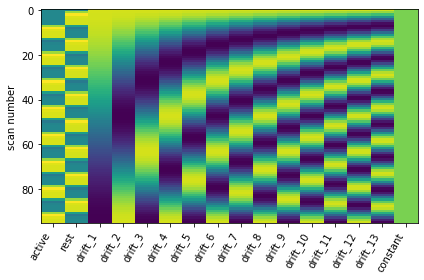

In [14]:
from nistats.reporting import plot_design_matrix
plot_design_matrix(design_matrix)
import matplotlib.pyplot as plt
plt.show()

La première colonne (`active`) nous indique la réponse attendue


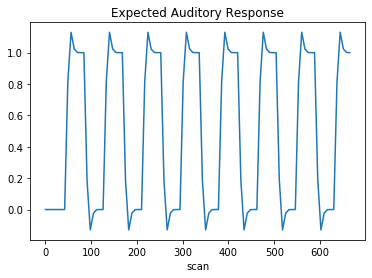

In [15]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

Calcul des contrastes
-----------------------------------------

Pour accéder aux coefficients estimés ($\beta$ du modèle GLM), nous
a créé un contraste avec un seul "1" dans chacune des colonnes : Le rôle
du contraste est de sélectionner quelques colonnes du modèle et
les pondérer pour étudier les statistiques associées. 

En bref, un contraste est une combinaison pondérée des
effets.  Nous pouvons ici définir des contrastes canoniques qui ne tiennent compte que
les deux effets isolés - appelons-les des "conditions". Un contraste qui fait la différence entre ces conditions.
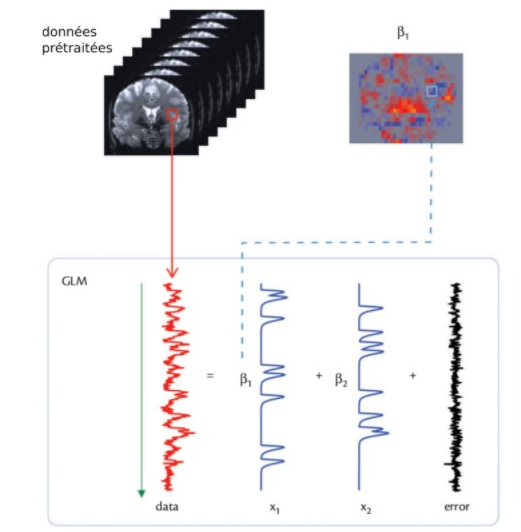

In [16]:
from numpy import array
conditions = {
    'active': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
    'rest':   array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
}

On peut comparer les conditions en définissant le contraste à faire


In [17]:
active_minus_rest = conditions['active'] - conditions['rest']

Le contraste que nous voulons s'illustre comme cela:



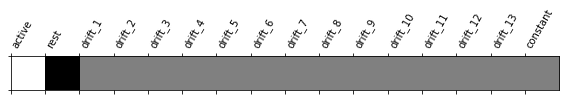

In [18]:
from nistats.reporting import plot_contrast_matrix
plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)

### Visualiser la carte de contraste
On peut calculer le contraste en utilisant la méthode `compute_contrast()` de notre modèle.

On peut accéder aux différentes méthodes et informations de notre modèle en l'appelant `fmri_glm`

Écrivez `fmri_glm.` et appuyez sur la touche tab : ``fmri_glm.<tab>``

In [19]:
#fmri_glm.

In [20]:
eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

#### pas tout à fait ce qu'on veut...
la carte ne nous dit pas grand chose, l'échelle correspond à la taille d'effet...

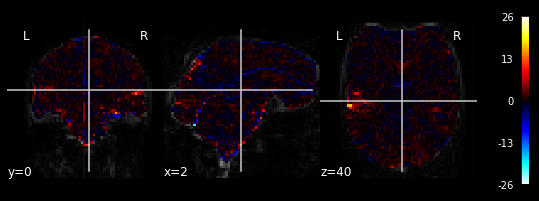

In [21]:
plot_stat_map(eff_map, bg_img=mean_img)

L'échelle z signifie que les valeurs de contraste
sont standardisés pour correspondre à une distribution gaussienne standard (moyenne = 0,
SD = 1). 


In [22]:
z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

## Visualiser les voxels significatifs

Nous affichons la carte d'activation sur la moyenne
image fonctionnelle de la série (cela pourrait être l'image anatomique de la
sujet).  

Nous utilisons un seuil arbitraire de 3,0 dans l'échelle z.



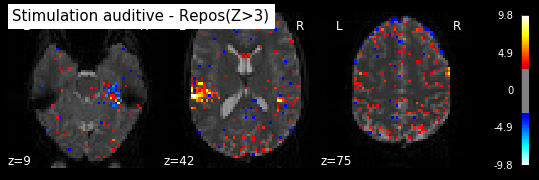

In [23]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Stimulation auditive - Repos(Z>3)')
plt.show()

## Tester la significativité statistique à l'aide de différentes corrections
### 1) Non-Corrigé


Uncorrected p<0.001 threshold: 3.291


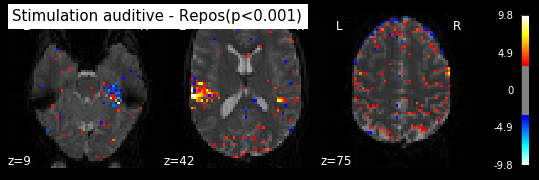

In [24]:
from nistats.thresholding import map_threshold
_, threshold = map_threshold(z_map, alpha=.001, height_control='fpr')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Stimulation auditive - Repos(p<0.001)')
plt.show()

#### Problème :
Ici, on s'attend à 0.1 % des voxels ressortent alors qu'ils ne sont pas nécessairement actifs. La raison pour cela est que le contraste s'effectue entre tous les voxels. Tous les voxels sont comparés entre eux. Au nombre de voxels qu'il y a, il est clair qu'un bon nombre d'entre eux ressortent comme actifs. Il y a une accumulation de l'erreur.

Un moyen de contrôler pour ce nombre important de comparaison est de diviser notre seuil par le nombre de comparaison effectué. On appelle ça couramment la correction de Bonferroni. On peut abaisser le seuil à 5%. La fonction appropriée divisera avec le nombre de comparaison à effectuer.
### 2) Correction de  Bonferronni (FamilyWise Error Rate - FWER)

Uncorrected p<0.001 threshold: 4.934


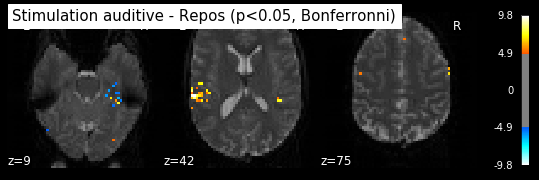

In [25]:
_, threshold = map_threshold(z_map, alpha=.05, height_control='bonferroni')
print('Uncorrected p<0.001 threshold: %.3f' % threshold)
plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Stimulation auditive - Repos (p<0.05, Bonferronni)')
plt.show()

#### Problème 
Cette manière de contrôler les effets est très conservatrice. On peut oberver les noyaux actifs dans le lobe temporal gauche; celui-ci est drastiquement plus petit avec cette correction. On pourrait penser que l'on supprime un effet réel avec cette correction. 

### 3) Correction de Taux de Fausses Découvertes (False Discovery Rate - FDR)
Une correction alternative est le FDR , où l'on s'intéresse à la proportion attendue de fausses découvertes (rejet incorrect de l'hypothèse nulle - Faux positifs). Cette correction augmente la puissance statistique de notre test (moins de rejet incorrect de l'hypothèse alternative, Faux négatifs), au prix d'augmenter les faux positifs.



Taux de fausse découverte (FDR) = 0.05 threshold: 2.905


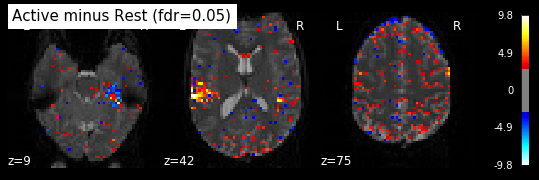

In [26]:
_, threshold = map_threshold(z_map, alpha=.05, height_control='fdr')

print('Taux de fausse découverte (FDR) = 0.05 threshold: %.3f' % threshold)

plot_stat_map(z_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr=0.05)')
plt.show()

#### Problème
Cette manière de contrôler les effets est moins conservatrice, mais elle semble trop sensible aux voxels "faussement activés". Nous pouvons en déduire ainsi en constatant que les activations sont étendues. Généralement, des petites activations disparates comme celles-ci nous indiquent un problème.

### 4) Correction FDR avec noyaux (FDR Clusters)
Nous pouvons adresser ce problème en imposant un seuil correspondant nombre de voxels co-activé. C'est-à-dire en ne rapportant que des activations de noyaux de voxels d'un nombre déterminé (ici, 10)

`cluster_threshold = 10` - Jouez avec ce paramètre et voyez la différence.

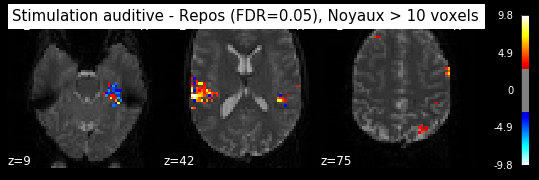

In [27]:
clean_map, threshold = map_threshold(z_map, alpha=.05, height_control='fdr', cluster_threshold=10)

plot_stat_map(clean_map, bg_img=mean_img, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Stimulation auditive - Repos (FDR=0.05), Noyaux > 10 voxels')
plt.show()

Maintenant, supposons qu'on veut publier ces résultats, nous avons besoin d'un tableau résumant les coordonnées des noyaux sur la figure.



In [28]:
from nistats.reporting import get_clusters_table
table = get_clusters_table(z_map, stat_threshold=threshold,
                           cluster_threshold=20)
table

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
0,1,-60.0,-6.0,42.0,9.811979,4050
1,1a,-63.0,6.0,36.0,8.601922,
2,1b,-63.0,0.0,42.0,8.399054,
3,1c,-48.0,-15.0,39.0,8.364058,
4,2,60.0,0.0,36.0,9.605128,1512
5,2a,45.0,-12.0,42.0,7.590200,
6,3,63.0,12.0,27.0,8.284500,972
7,3a,51.0,3.0,30.0,6.968355,
8,3b,54.0,9.0,39.0,3.565609,
9,4,36.0,-3.0,15.0,8.087451,1188
